In [1]:
import kagglehub
path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", path)

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\yonat\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1


In [36]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
IMAGE_PATH = 'C:/Users/yonat/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images'
CAPTION_PATH = 'C:/Users/yonat/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/captions.txt'

CODE_PATH = 'C:/Users/yonat/OneDrive/Documents/Binus/Semester_5/Deep Learning/VSCode/aol'

In [8]:
features = {}

for image_name in tqdm(os.listdir(IMAGE_PATH)):
    img = load_img(f'{IMAGE_PATH}/{image_name}', target_size=(224,224))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    feature = model.predict(img, verbose=0)
    img_id = image_name.split('.')[0]
    features[img_id] = feature

100%|██████████| 8091/8091 [19:52<00:00,  6.78it/s]


In [9]:
pickle.dump(features, open(os.path.join(CODE_PATH,'features.pkl'), 'wb'))

In [10]:
with open(os.path.join(CODE_PATH,'features.pkl'), 'rb') as f:
    features = pickle.load(f)

with open(CAPTION_PATH, 'r') as f:
    next(f)
    captions = f.read()

In [11]:
captions_dict = {}

for caption in tqdm(captions.split('\n')):
    tokens = caption.split(',')
    if len(caption) < 2:
        continue
    img_id, caption = tokens[0], tokens[1:]
    img_id = img_id.split('.')[0]
    caption = ' '.join(caption)

    if img_id not in captions_dict:
        captions_dict[img_id] = []
    captions_dict[img_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 991201.42it/s]


In [12]:
def clean_captions(captions_dict):
    for img_id, captions in captions_dict.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^a-zA-Z]','')
            caption = caption.replace('\s+', ' ')
            caption = 'start ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' end'
            captions[i] = caption

In [13]:
captions_dict['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
clean_captions(captions_dict)

In [15]:
captions_dict['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [22]:
cleaned_captions = []
for key in captions_dict:
    for caption in captions_dict[key]:
        cleaned_captions.append(caption)

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1

In [24]:
max_length = max(len(caption.split()) for caption in cleaned_captions)

In [26]:
img_ids = list(captions_dict.keys())
split = int(len(img_ids) * 0.80)
train = img_ids[:split]
test = img_ids[split:]

In [28]:
img_input = Input(shape=(4096,))
img_dropout = Dropout(0.4)(img_input)
img_dense = Dense(256, activation='relu')(img_dropout)

seq_input = Input(shape=(max_length,))
seq_embedding = Embedding(vocab_size, 256, mask_zero=True)(seq_input)
seq_dropout = Dropout(0.4)(seq_embedding)
seq_lstm = LSTM(256)(seq_dropout)

decoder_add = add([img_dense, seq_lstm])
decoder_dense = Dense(256, activation='relu')(decoder_add)
final_output = Dense(vocab_size, activation='softmax')(decoder_dense)

model = Model(inputs=[img_input, seq_input], outputs=final_output)
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [30]:
def tf_data_generator(img_keys, captions_dict, features, tokenizer, max_length, vocab_size, batch_size):
    def generator():
        x1, x2, y = list(), list(), list()
        n = 0
        for key in img_keys:
            captions = captions_dict[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)
                    n += 1

                    if n == batch_size:
                        yield (np.array(x1), np.array(x2)), np.array(y)
                        x1, x2, y = list(), list(), list()
                        n = 0
    
    output_signature = (
        (
            tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),  
            tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)  
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32) 
    )
    
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)


In [31]:
epochs = 15
batch_size = 64
train_dataset = tf_data_generator(train, captions_dict, features, tokenizer, max_length, vocab_size, batch_size)
steps = len(train) // batch_size

for i in range(epochs):
    model.fit(train_dataset, epochs=1, steps_per_epoch=steps, verbose=1)

101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 7.0011
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 5.1687
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 4.6338
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 4.3514
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 4.0709
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 3.6153
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 3.4527
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 3.2467
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 3.0716
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 2.9565
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 2.8057
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 2.5438
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 2.4630
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 2.3311
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 2.1927


In [32]:
model.save(CODE_PATH + '/caption_model.h5')

In [33]:
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [34]:
def generate_caption(model, image, tokenizer, max_length):
    generated_caption = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([generated_caption])[0]
        sequence = pad_sequences([sequence], max_length)
        predicted_probs = model.predict([image, sequence], verbose=0)
        predicted_index = np.argmax(predicted_probs)
        predicted_word = index_to_word(predicted_index, tokenizer)
        if predicted_word is None:
            break
        generated_caption += " " + predicted_word
        if predicted_word == 'end':
            break
    return generated_caption


In [35]:
actual, predicted = list(), list()

for key in tqdm(test):
    captions = captions_dict[key]
    y_pred = generate_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    actual.append(actual_captions)
    predicted.append(y_pred)



100%|██████████| 1619/1619 [18:48<00:00,  1.43it/s]


In [37]:
print("Bleu-1: %f" % corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
print("Bleu-2: %f" % corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))
print("Bleu-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


Bleu-1: 0.357167
Bleu-2: 0.179519
Bleu-4: 0.047825


In [38]:
def caption_generator(image_name):
    img_id = image_name.split('.')[0]
    img_path = os.path.join(IMAGE_PATH,image_name)
    img = Image.open(img_path)
    captions = captions_dict[img_id]
    
    print('Actual')
    for caption in captions:
        print(caption)
    y_pred = generate_caption(model, features[img_id], tokenizer, max_length)
    print('')
    print('Predicted')
    print(y_pred)
    plt.imshow(img)

Actual
start black dog running in the surf end
start black lab with tags frolicks in the water end
start dog splashes in the water end
start the black dog runs through the water end
start this is black dog splashing in the water end

Predicted
start black lab running in the water end


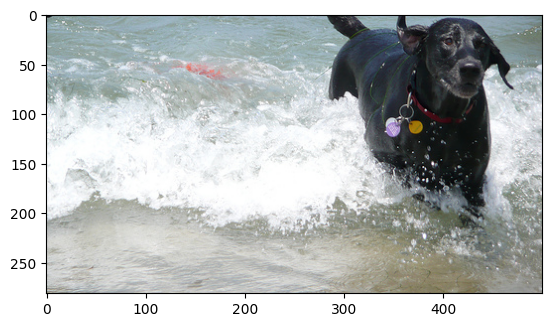

In [40]:
caption_generator('1022975728_75515238d8.jpg')

Actual
start boy in yellow shorts is standing on top of cliff end
start boy wearing blue and yellow walking on cliff edge end
start little boy standing high in the air on rock end
start young child is standing alone on some jagged rocks end
start child stands near edge of cliff end

Predicted
start child standing on cliff end


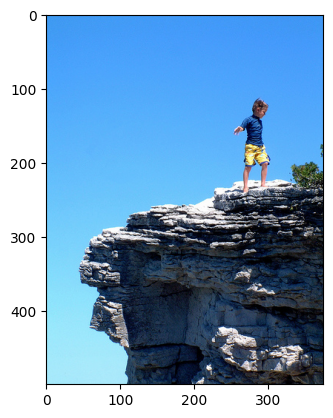

In [41]:
caption_generator('109671650_f7bbc297fa.jpg')

Actual
start guy stands in the sand with snowboard behind him end
start man holds surfboard on the beach end
start man holds his snowboard in the sand end
start man with his surfboard stands in the sand end
start man is standing on white sand and holding snowboard end

Predicted
start man holds surfboard on the sand end


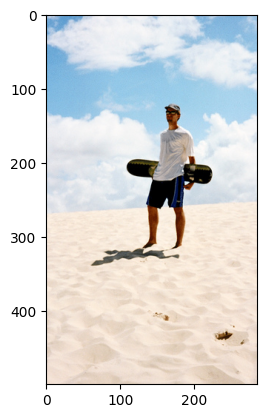

In [42]:
caption_generator('112178718_87270d9b4d.jpg')

Actual
start half naked man is sleeping on his chair outdoors end
start an older man sits back and relaxes on patio outside an adobe building where many bicycles are propped end
start "a shirtless man in white cap relaxes in deck chair close to three parked bicycles ." end
start man relaxing in folding chair on the street end
start "topless old man wearing slippers navy blue pants and white hat while reclining in chair outside ." end

Predicted
start a man relaxing back back back and relaxes and relaxes and relaxes and relaxes and relaxes and relaxes and relaxes and older relaxes and older older older older older older older relaxes relaxes relaxes and


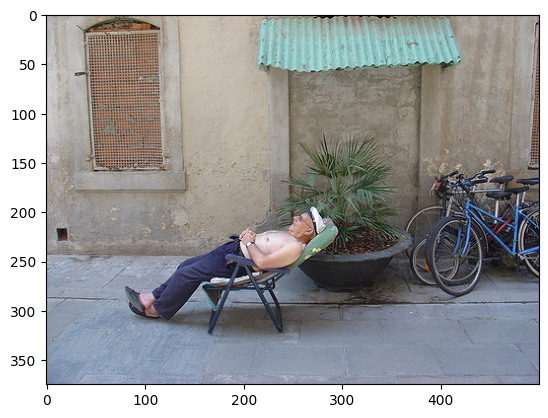

In [44]:
caption_generator('1124448967_2221af8dc5.jpg')